In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib as mpl
mpl.style.use('./style.mcstyle')   # noqa
from matplotlib import pyplot as plt
import astropy
import pandas as pd
from astropy.io import fits
from tqdm import tqdm
import h5py
from collections import defaultdict

from astropy.cosmology import Planck18
cosmo = Planck18

In [ ]:
# check what is run

from collections import defaultdict
suitedir = '/ocean/projects/phy240015p/mho1/cmass-ili/mtnglike/fastpm_constrained_newz/L3000-N384'

record = {}

lhidlist = os.listdir(suitedir)
tracers = [f'{cap}_lightcone' for cap in ['simbig', 'sgc', 'mtng', 'ngc']]
for t in tracers:
    record[t] = defaultdict(lambda: 0)

for lhid in tqdm(lhidlist):
    simdir = join(suitedir, lhid)
    if not os.path.isdir(simdir):
        continue
    for tracer in tracers:
        diagdir = join(simdir, 'diag', tracer)
        if not os.path.isdir(diagdir):
            continue
        diaglist = os.listdir(diagdir)
        for d in diaglist:
            diagfile = join(diagdir, d)
            with h5py.File(diagfile, 'r') as f:
                for k in f.keys():
                    record[tracer][k] += 1

for k, d in record.items():
    print('\n', k)
    for key, value in d.items():
        print(f"\t{key}:\t{value}")

100%|██████████| 3000/3000 [03:47<00:00, 13.21it/s]


 simbig_lightcone
	nz:	2355
	nz_bins:	2355

 sgc_lightcone
	nz:	2345
	nz_bins:	2345

 mtng_lightcone
	nz:	2334
	nz_bins:	2334

 ngc_lightcone
	nz:	2323
	nz_bins:	2323


In [5]:
# check n(z)'s

from collections import defaultdict
suitedir = '/ocean/projects/phy240015p/mho1/cmass-ili/mtnglike/fastpm_constrained/L3000-N384'

record = {}

lhidlist = os.listdir(suitedir)
tracers = [f'{cap}_lightcone' for cap in ['simbig', 'sgc', 'mtng', 'ngc']]
for t in tracers:
    record[t] = defaultdict(lambda: [])

for lhid in tqdm(lhidlist[::10]):
    simdir = join(suitedir, lhid)
    if not os.path.isdir(simdir):
        continue
    for tracer in tracers:
        diagdir = join(simdir, 'diag', tracer)
        if not os.path.isdir(diagdir):
            continue
        diaglist = os.listdir(diagdir)
        for d in diaglist:
            diagfile = join(diagdir, d)
            with h5py.File(diagfile, 'r') as f:
                if 'nz' in f:
                    record[tracer]['nz'].append(f['nz'][:])
                    record[tracer]['cosmo'].append(f.attrs['cosmo_params'])
                    record[tracer]['hod'].append(f.attrs['HOD_params'])

100%|██████████| 300/300 [01:20<00:00,  3.71it/s]


In [6]:
for k, d in record.items():
    print('\n', k)
    for key, value in d.items():
        print(f"\t{key}:\t{len(value)}")


 simbig_lightcone
	nz:	342
	cosmo:	342
	hod:	342

 sgc_lightcone
	nz:	342
	cosmo:	342
	hod:	342

 mtng_lightcone
	nz:	342
	cosmo:	342
	hod:	342

 ngc_lightcone
	nz:	1485
	cosmo:	1485
	hod:	1485


In [7]:

from astropy.stats import scott_bin_width
from scipy.interpolate import InterpolatedUnivariateSpline
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
from cmass.diagnostics.geometry import SURVEY_GEOMETRIES


def get_nofz(zhist, zedges, fsky, cosmo):

    # Calculate comoving volume of each spherical shell corresponding to a bin
    R_hi = cosmo.comoving_distance(zedges[1:]).to_value(u.Mpc) * cosmo.h
    R_lo = cosmo.comoving_distance(zedges[:-1]).to_value(u.Mpc) * cosmo.h
    dV = (4./3.) * np.pi * (R_hi**3 - R_lo**3) * fsky

    # Avoid division by zero for empty bins
    dV[dV == 0] = np.inf

    # Create a spline interpolator for n(z)
    nofz = InterpolatedUnivariateSpline(
        0.5*(zedges[1:] + zedges[:-1]), zhist/dV, ext='const')
    return nofz

In [8]:

zedges = np.linspace(0.4, 0.7, 101)
zcens = 0.5 * (zedges[1:] + zedges[:-1])
for t in tracers:
    print(t)
    fsky = SURVEY_GEOMETRIES[t.split('_')[0]]['fsky']
    nofzs = []

    for k in tqdm(record[t]['nz']):
        nofz = get_nofz(k, zedges, fsky, cosmo)
        _y = nofz(zcens)
        nofzs.append(_y)

    record[t]['nofz'] = np.array(nofzs)

simbig_lightcone


100%|██████████| 342/342 [00:01<00:00, 332.70it/s]


sgc_lightcone


100%|██████████| 342/342 [00:00<00:00, 403.00it/s]


mtng_lightcone


100%|██████████| 342/342 [00:00<00:00, 350.20it/s]


ngc_lightcone


100%|██████████| 1485/1485 [00:03<00:00, 404.28it/s]


In [9]:
trues = {}

datafiles = {
    'simbig_lightcone': '/ocean/projects/phy240015p/mho1/cmass-ili/real_data/cmass_simbig/L2000-N256/0/simbig_lightcone/hod00000_aug00000.h5',
    'sgc_lightcone': '/ocean/projects/phy240015p/mho1/cmass-ili/real_data/cmass_sgc/L2000-N256/0/sgc_lightcone/hod00000_aug00000.h5',
    'mtng_lightcone': '/ocean/projects/phy240015p/mho1/cmass-ili/mtng/nbody/L3000-N384/0/mtng_lightcone/hod00000_aug00000.h5',
    'ngc_lightcone': '/ocean/projects/phy240015p/mho1/cmass-ili/real_data/cmass_ngc/L3000-N384/0/ngc_lightcone/hod00000_aug00000.h5',
}


for t, filename in datafiles.items():
    with h5py.File(filename, 'r') as f:
        redshifts = f['z'][:]
    fsky = SURVEY_GEOMETRIES[t.split('_')[0]]['fsky']
    nz = np.histogram(redshifts, bins=zedges)[0]
    nofz = get_nofz(nz, zedges, fsky, cosmo)(zcens)
    trues[t] = {
        'nz': nz,
        'nofz': nofz
    }

Text(0.5, 0, '$z$')

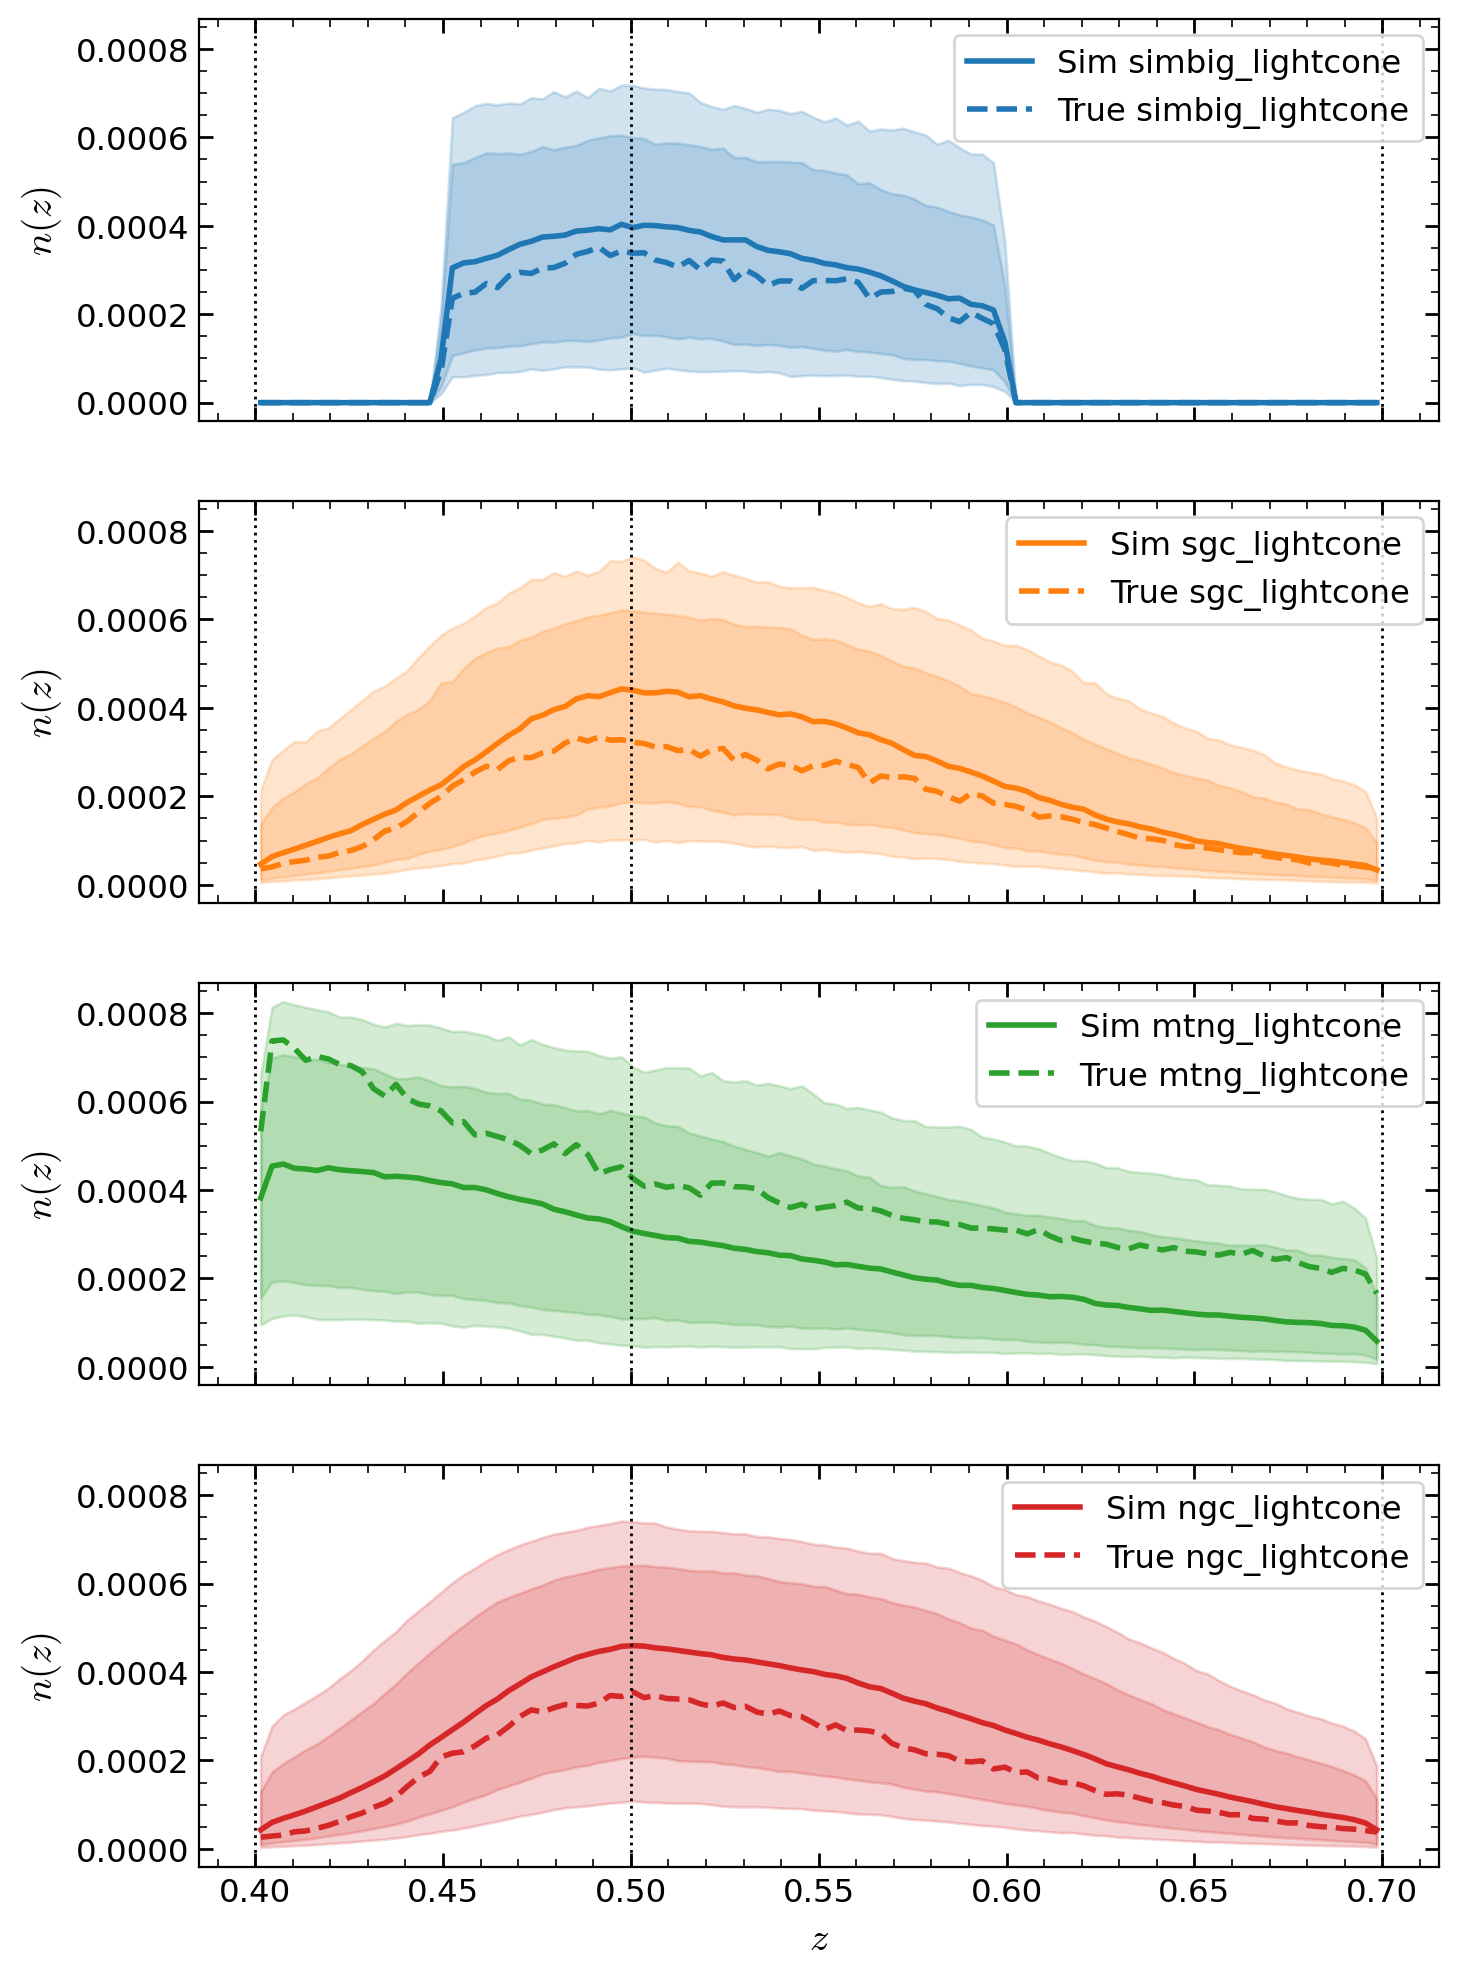

In [10]:
f, axs = plt.subplots(4, 1, figsize=(8, 12), sharex=True, sharey=True)
for i, t in enumerate(tracers):
    ax = axs[i]
    _x = zcens
    _y = record[t]['nofz']
    percs = np.percentile(_y, [50, 16, 84, 5, 95], axis=0)
    ax.fill_between(_x, percs[1], percs[2], alpha=0.2, color=f'C{i}')
    ax.fill_between(_x, percs[3], percs[4], alpha=0.2, color=f'C{i}')
    ax.plot(_x, percs[0], label=f'Sim {t}', color=f'C{i}')

    ax.plot(_x, trues[t]['nofz'], '--', color=f'C{i}', label=f'True {t}')
    ax.set(ylabel='$n(z)$')
    ax.legend()

    for zbin in [0.4, 0.5, 0.7]:
        ax.axvline(zbin, color='k', linestyle=':', alpha=1, lw=1)
ax.set_xlabel('$z$')

Text(0.5, 0, '$z$')

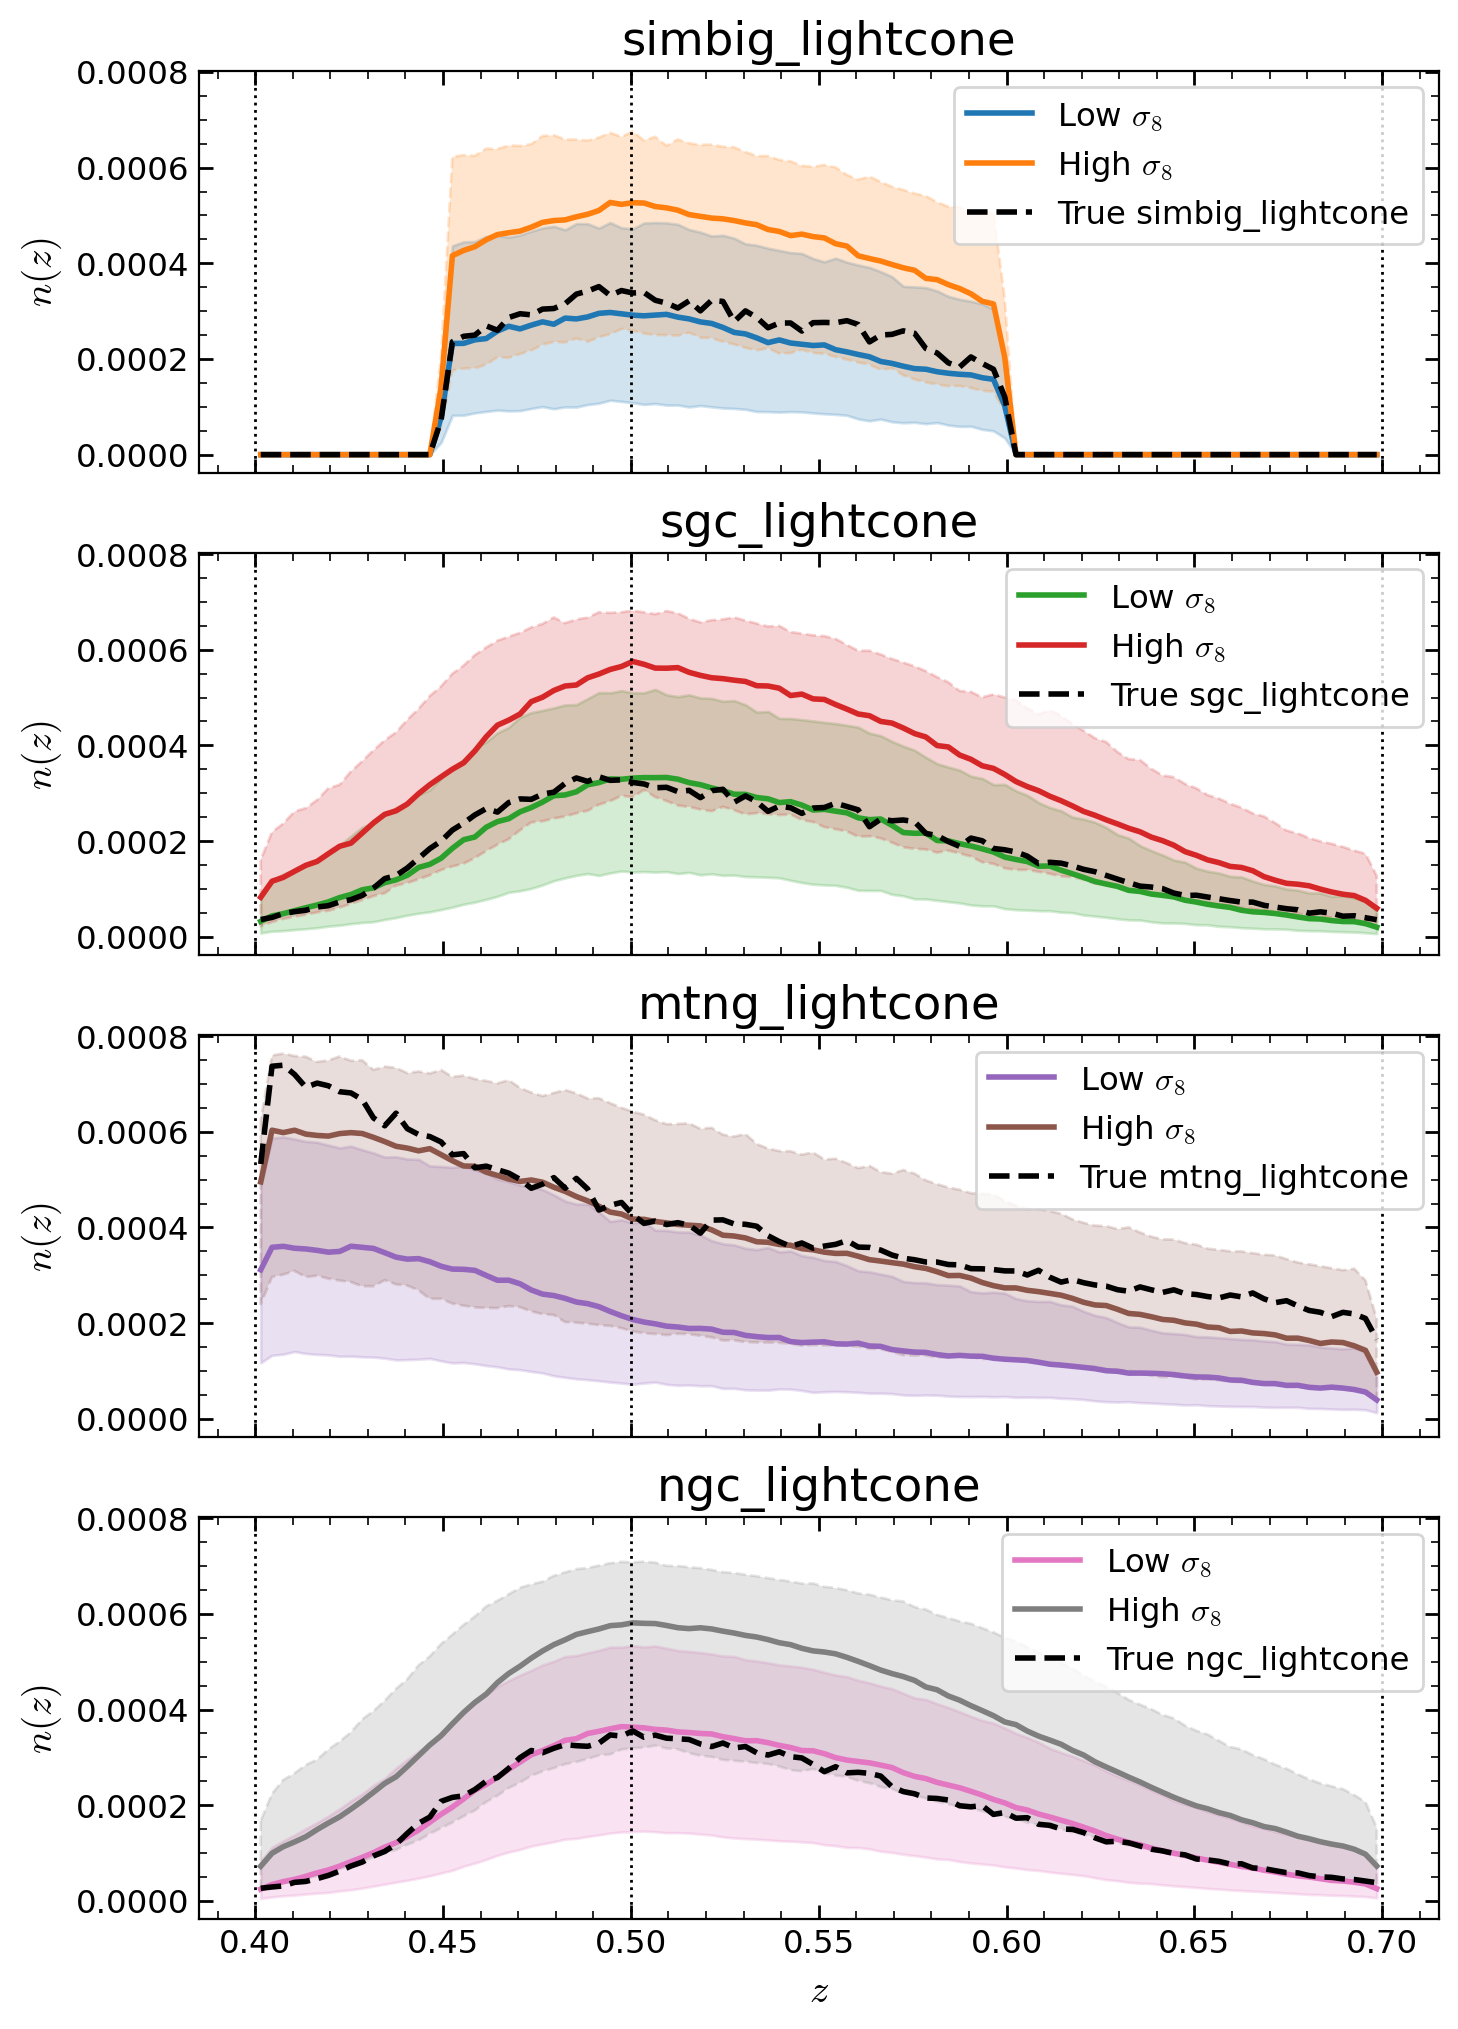

In [ ]:
f, axs = plt.subplots(4, 1, figsize=(8, 12), sharex=True, sharey=True)

param = r'$\sigma_8$'
mid = 0.8159
ind = 4

for i, t in enumerate(tracers):
    ax = axs[i]
    _c = np.array(record[t]['cosmo'])
    _x = zcens
    _y = record[t]['nofz']
    percs = np.percentile(_y, [50, 16, 84], axis=0)

    # Split into two contours based on _c[:, 0]
    mask = _c[:, ind] < mid
    percs = np.percentile(_y[mask], [50, 16, 84], axis=0)
    ax.fill_between(_x, percs[1], percs[2], alpha=0.2, color=f'C{2*i}')
    ax.plot(_x, percs[0], label=f'Low {param}', color=f'C{2*i}')
    percs = np.percentile(_y[~mask], [50, 16, 84], axis=0)
    ax.fill_between(_x, percs[1], percs[2], alpha=0.2,
                    color=f'C{2*i+1}', linestyle='--')
    ax.plot(_x, percs[0], label=f'High {param}', color=f'C{2*i+1}')

    ax.plot(_x, trues[t]['nofz'], '--', color='k', label=f'True {t}')
    ax.set(ylabel='$n(z)$')
    ax.legend()
    ax.set_title(t)

    for zbin in [0.4, 0.5, 0.7]:
        ax.axvline(zbin, color='k', linestyle=':', alpha=1, lw=1)
ax.set_xlabel('$z$')